# Relative length of articles by language on Wikipedia - Julien VERNEAUT

## Introduction
### Hypothesis
When searching for something on the web, I often find that there is much more content available in English than in French. As obvious as this is to me, I wanted to get some data to support this hypothesis.

### Protocol
Wikipedia is one of the biggest source of quality content in the world. As of september 2018, the english version had in excess of 5,700,000 unique articles with more than 500 news per day. This will be our database.

Using [the Monte Carlo method](https://en.wikipedia.org/wiki/Monte_Carlo_method), we will sample random articles for every languages and count the average character length of this corpus.

As the Wikimedia API doesn't provide a clean way to get the character length of an article, we will get this information like this:
1. Wikimedia's API provides the byte size of every article.
2. Average the bytes per character over a big numer of article in the specified langage using the Monte Carlo method.
3. Divide the byte size by the the bytes per character to get an approximation of the average character length of articles in this language.

As we are using the Monte Carlo method to average the byte size and the character length of articles, we will need to use a big sample size to minimize the error.
Wikimedia API docs provide the following limitations:
- No more than 500 random articles per request.
- No more than 50 article's content per request.

In a compromise between limitations, precision and time, I chose to sample 5000 articles to get the byte sizes and 250 to get the bytes per characters. Past that size, the fluctuation in results isn't statistically significant anymore.

### Limitations
As is, the Wikimedia returns its own wikitext format when asked for the content of an article. This isn't actual text and ressembles html. As all languages uses the same format, I don't think that this would bias the results.

Some languages are more verbose than others. For example in French we say "Comment est-ce que tu vas ?" (27 char.) while in English we say the shortest "How are you?" (12 char.). I'm considering analysing books traductions in different languages to gauge the verbosity of every language. I will update these results once I have enough data to do so.

## Getting the average byte size of articles in every language

In [1]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 160

We will be studying the biggest 15 versions by number of articles according to [Wikimedia](https://meta.wikimedia.org/wiki/List_of_Wikipedias).

In [2]:
languages = ["en", "ceb", "sv", "de", "fr", "nl", "ru", "es", "it", "pl", "war", "vi", "ja", "zh", "pt"]
df = pd.DataFrame({"Locales": languages})

This function takes a locale (ex: "fr", "en", etc.) and returns the url to get 500 random articles in this language with information about their size.

In [3]:
def getRandomArticlesUrl(locale):
    return "https://" + locale + ".wikipedia.org/w/api.php?action=query&generator=random&grnlimit=500&grnnamespace=0&prop=info&format=json"

This function takes a locale and outputs a dict of articles.

In [4]:
def getArticles(locale):
    url = getRandomArticlesUrl(locale)
    response = requests.get(url)
    return json.loads(response.content)["query"]["pages"]

This function go over every articles and return their added byte lengths.

In [5]:
def getByteSizeOfArticles(articles):
    count = 0
    for i in range(500):
        count = count + articles.values()[i]["length"]
    return count

This function sums the byte size of batches of articles and averages it by article.

In [6]:
def getAverageByteSizeOfArticle(locale, iterations=100):
    count = 0.0
    for i in range(iterations):
        articles = getArticles(locale)
        count = count + getByteSizeOfArticles(articles)
    return (count / iterations) / 500

This block of code goes over every locale, calculate average article byte size and add the results to the dataframe.

In [7]:
start_time = time.time()
byte_sizes = []
for locale in df["Locales"]:
    byte_size = getAverageByteSizeOfArticle(locale)
    byte_sizes.append(byte_size)
    print("%s: average of %s bytes" % (locale, byte_size))
df["Average byte size"] = byte_sizes

print("Executed in %s seconds." % (time.time() - start_time))

en: average of 6950.62798 bytes
ceb: average of 5513.71082 bytes
sv: average of 4059.55772 bytes
de: average of 5874.15554 bytes
fr: average of 6331.53984 bytes
nl: average of 2317.88802 bytes
ru: average of 9413.11996 bytes
es: average of 5915.6691 bytes
it: average of 5489.32844 bytes
pl: average of 4461.17704 bytes
war: average of 1741.87038 bytes
vi: average of 2416.81136 bytes
ja: average of 7934.51844 bytes
zh: average of 4293.65174 bytes
pt: average of 4680.16966 bytes
Executed in 595.583205938 seconds.


In [8]:
df = df.sort_values("Average byte size", ascending=False)
df.set_index("Locales",drop=True,inplace=True)
df

,Average byte size
Locales,
ru,9413.11996
ja,7934.51844
en,6950.62798
fr,6331.53984
es,5915.66910
de,5874.15554
ceb,5513.71082
it,5489.32844
pt,4680.16966


(-1.1031906447545428,
 1.1001519519372347,
 -1.1054680749554677,
 1.2085610213646203)

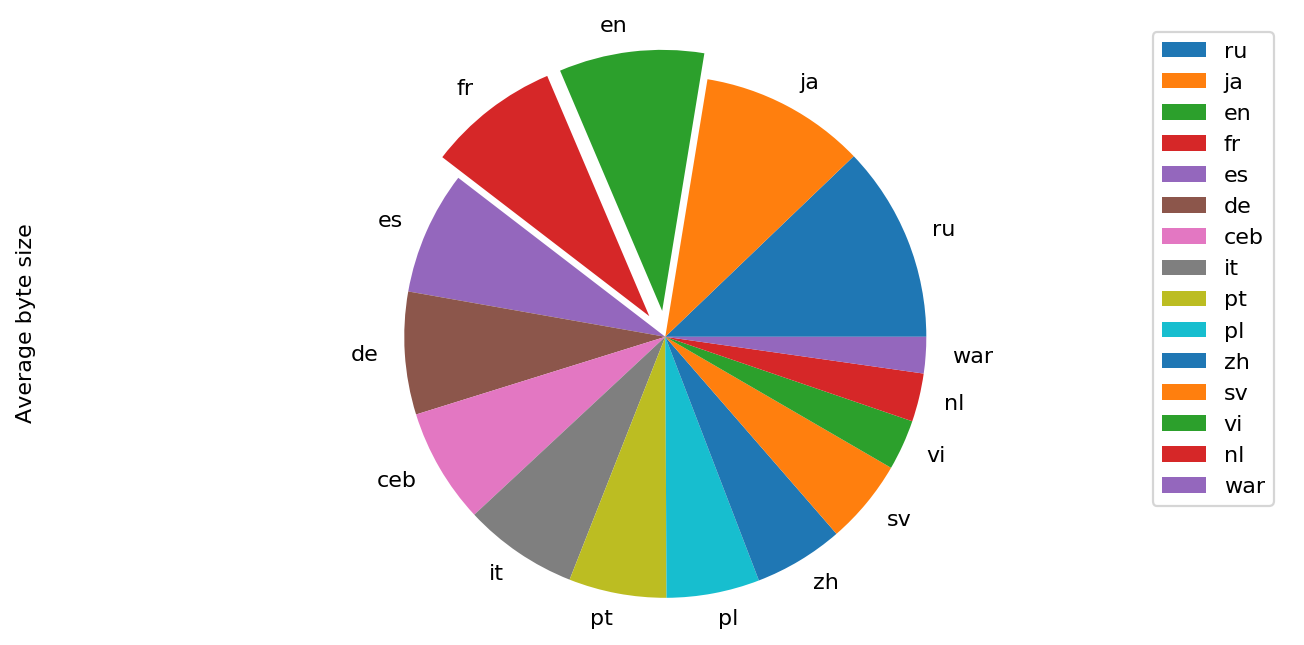

In [9]:
locales_to_highlight = ["en", "fr"]
explode = []
for i in range(len(df["Average byte size"])):
    if df.index[i] in locales_to_highlight:
        explode.append(0.1)
    else:
        explode.append(0)
df.plot.pie(y="Average byte size", explode=explode)
plt.axis("equal")

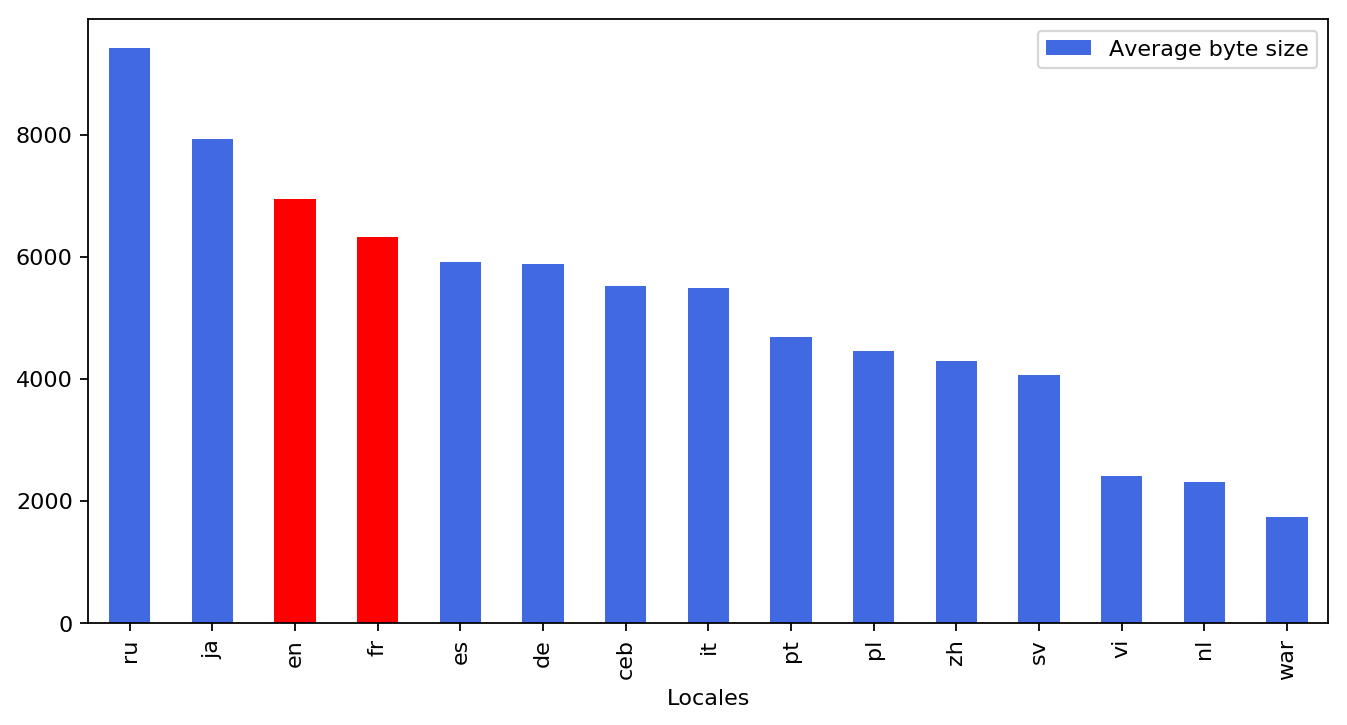

In [10]:
colors = []
for i in range(len(df["Average byte size"])):
    if df.index[i] in locales_to_highlight:
        colors.append("red")
    else:
        colors.append("royalblue")
df.plot.bar(y="Average byte size", color=[(colors)])

### First results

From the above charts, we can see that English articles tend to have a bigger byte size than French ones.

Russian and Japan tend to have articles of bigger byte size than other languages. How can that be? Let's look into what is in a byte.

***
## How characters are encoded: UTF-8 short introduction

### What is a bit, a byte and how to count in binary

Unlike humans, a computer doesn't understand the alphabet. He doesn't know our numbers, let alone our alphabet. To him, everything is represented in 0 and 1.

In our decimal number system, we count from 0 to 1, 1 to 2, ..., 8 to 9 and when then we go to 0 and add 1 to the decimals and get 10.

In the binary system you go from 0 to 1, then to 0 again and add 1 to the next binary place and get 10. Then 11, then 100, 101, 110, 111, etc.

| Decimal | Binary |
|---------|--------|
|0|0|
|1|1|
|2|10|
|3|11|
|4|100|
|5|101|
|6|110|
|7|111|
|8|1000|
|9|1001|
|10|1010|
|...|...|

Teaching binary is outside the scope of this article, but I just want you to see that the bigger the number, the "longer" the binary number is (each 0 or 1 is called a bit).

A computer doesn't know how to use arbitrary number of bits, so it store number in group of bits.

8 bits is called a byte and the biggest number you can write with it is 
    1    1    1    1   1   1   1   1
= 128 + 64 + 32 + 16 + 8 + 4 + 2 + 1
= 255.

### How UTF-8 stores characters

Storing letters is a little more complicated. The latin alphabet used in most occidental countries uses 26 letters.

Couldn't we store a lookup table where each letter is assigned a number?

| Letter | Number | Binary |
|--------|--------|--------|
|A|0|00000000|
|B|1|00000001|
|C|2|00000010|
|D|3|00000011|
|...|...|...|
|Z|25|00011001|

This is more or less how your computer stores characters. So you would say, if a byte is sufficient, why do we need to invent other storing methods?

Turns out there is more to characters than letters. In fact, in very this phrase, you can see uppercase letters, comas, etc.
The list of these basic latin characters is called [ASCII](https://en.wikipedia.org/wiki/ASCII).

At the dawn of computing, ASCII was more than enough for basic computer uses. But what if we need more characters? What if we want to write in the cyrillic alphabet (33 letters)? It's for that very reason that UTF-8 was created.

UTF-8 stands for Unicode (or Universal Coded Character Set) Transformation Format – 8-bit. It's an encoding that allows a computer to store characters on a single or on mutiple bytes.

The first few bits of the first UTF-8 byte tells us the length of the character.

|First bits of first byte of UTF-8|Number of bytes|
|--|--|
|0xxxxxxx|1|
|110xxxxx ...|2|
|1110xxxx ... ...|3|
|11110xxx ... ... ...|4|

The following bytes also uses a special encoding and must begin with 10. If you are interested and want to learn more about that specific subject, check [the excellent article on Wikipedia](https://en.wikipedia.org/wiki/UTF-8).

At mimimum, we can see that UTF-8 uses 1 bit to store the length. It means that at maximum we can store 1111111 = 127 characters on a byte. For the English language, that is plenty enough most of the time. In French, we use accents like "à", "é", "ô", etc. so we can suppose that we need more bytes to encode similar texts.

If we look at our data, we can see that Russian and Japanese articles are the biggest in term of byte size. But with 33 and 71 letters in their alphabets respectively, these results were to be expected.
***

## Getting the average bytes per characters of articles in every language

Wikimedia API exposes an other endpoint that let us get the content and the byte size of the article.

Why didn't I use it for the first part ? This endpoint can only send 50 results at the same time and thus is 10x slower to use than the first one. At about 20 minutes, the first request would have taken 3 hours and 20 minutes.

I will only use it to get the best approximation I can about the number of bytes used to encode 1 character in every language. We will get about 250 articles to sample from for each languages but the results aren't supposed to change much from article to article.

The code is mostly the same as in part one so comments are omitted.

In [11]:
def getRandomArticlesUrl(locale):
    return "https://" + locale + ".wikipedia.org/w/api.php?action=query&generator=random&grnlimit=50&grnnamespace=0&prop=revisions&rvprop=content|size&format=json"

In [12]:
def getArticles(locale):
    url = getRandomArticlesUrl(locale)
    response = requests.get(url)
    return json.loads(response.content)["query"]["pages"]

In [13]:
def getByteSizeOfArticles(articles):
    count = 0
    for i in range(50):
        count = count + articles.values()[i]["revisions"][0]["size"]
    return count

In [14]:
def getContentSizeOfArticles(articles):
    count = 0
    for i in range(50):
        count = count + len(articles.values()[i]["revisions"][0]["*"])
    return count

In [15]:
def getAverageBytesPerCharOfArticles(locale, iterations=50):
    byte_count = 0.0
    char_count = 0.0
    for i in range(iterations):
        articles = getArticles(locale)
        byte_count = byte_count + getByteSizeOfArticles(articles)
        char_count = char_count + getContentSizeOfArticles(articles)
    return byte_count/char_count

In [16]:
start_time = time.time()
bytes_per_char = []
for locale in df.index:
    bytes_per_char_locale = getAverageBytesPerCharOfArticles(locale)
    bytes_per_char.append(bytes_per_char_locale)
    print("%s: average of %s chars per byte" % (locale, bytes_per_char_locale))
df["Average bytes per chars"] = bytes_per_char

print("Executed in %s seconds." % (time.time() - start_time))

ru: average of 1.54690600645 chars per byte
ja: average of 1.89668440419 chars per byte
en: average of 1.00536933698 chars per byte
fr: average of 1.02461620228 chars per byte
es: average of 1.01625269531 chars per byte
de: average of 1.01353837713 chars per byte
ceb: average of 1.00160831587 chars per byte
it: average of 1.00646893199 chars per byte
pt: average of 1.01973896479 chars per byte
pl: average of 1.03253513868 chars per byte
zh: average of 1.55616126488 chars per byte
sv: average of 1.012021056 chars per byte
vi: average of 1.11864924964 chars per byte
nl: average of 1.0036388177 chars per byte
war: average of 1.00072311703 chars per byte
Executed in 703.546710968 seconds.


In [17]:
df["Corrected char length of articles"] = df["Average byte size"] / df["Average bytes per chars"]
df = df.sort_values("Corrected char length of articles", ascending=False)
df

,Average byte size,Average bytes per chars,Corrected char length of articles
Locales,,,
en,6950.62798,1.005369,6913.507031
fr,6331.53984,1.024616,6179.425843
ru,9413.11996,1.546906,6085.127293
es,5915.66910,1.016253,5821.061166
de,5874.15554,1.013538,5795.691286
ceb,5513.71082,1.001608,5504.857271
it,5489.32844,1.006469,5454.046584
pt,4680.16966,1.019739,4589.576177
pl,4461.17704,1.032535,4320.605540


(-1.1071759895415623,
 1.1997784416282586,
 -1.1019386026333882,
 1.1174592213231753)

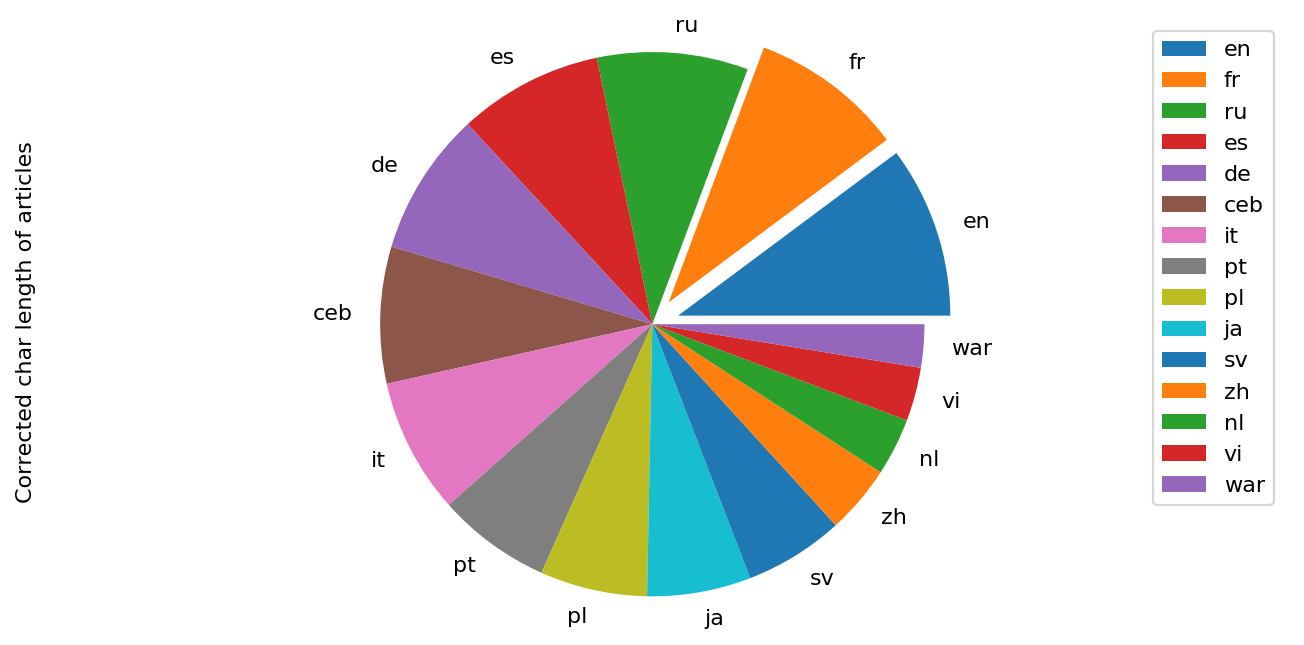

In [18]:
locales_to_highlight = ["en", "fr"]
explode = []
for i in range(len(df["Corrected char length of articles"])):
    if df.index[i] in locales_to_highlight:
        explode.append(0.1)
    else:
        explode.append(0)
df.plot.pie(y="Corrected char length of articles", explode=explode)
plt.axis("equal")

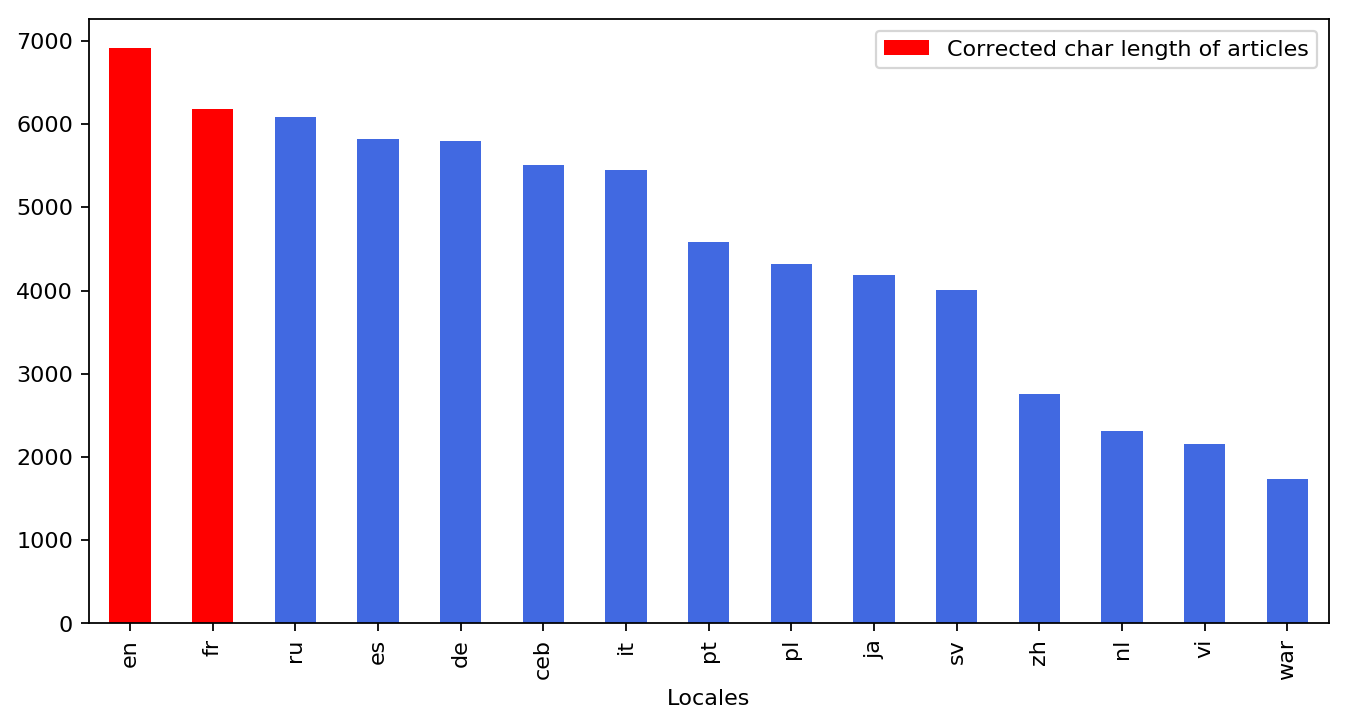

In [19]:
colors = []
for i in range(len(df["Corrected char length of articles"])):
    if df.index[i] in locales_to_highlight:
        colors.append("red")
    else:
        colors.append("royalblue")
df.plot.bar(y="Corrected char length of articles", color=[(colors)])

## Conclusion

From our results, we can see that English Wikipedia has the more content length. Unsurprisingly, the most popular version get to have the most content.

For a given subject, if you were given to chose a language to do you research in, my recommendation would thus be to pick English. French is not very far, however.

As discussed in the introduction, these results are to be taken for what they are: estimations of the character length of the average article for a given language. It doesn't take into account brevity or verbosity of said languages.

As this analysis rely on sampling and on the Monte Carlo method, its accuracy increases the more data you feed it. As is, the requests for this article took almost 20 minutes to execute. This is 20 minutes of Wikimedia CPU time. If you want to replicate this expermiment, be kind and don't push these numbers too high. At the time of writing, this falls into fair use of the API. Please make sure that you are not interfering in any way with Wikipedia and its products.

***
In the real world, data isn't always available in the exact form you would have wanted it to be.

In this article, I showed you how you can start from a problem, get data and then work your way around it to get insights from it.

I hope that you had as much fun reading this as I had writing it and hope to see you read more of my content soon.

[Julien VERNEAUT](https://www.julienverneaut.com)


[Linkedin](https://linkedin.com/in/julien-verneaut)